# Category Learning with Varying Dimensions

Experiment design document. February 22, 2018.

## Preamble and setup

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../mcmcp-bigan-generator-web-service/')
from generate import floatX, load_params, _render_image

In [2]:
model_dir = '../mcmcp-bigan-generator-web-service/exp/imagenet_1000_size72_u-200_bigan/models'
load_params(model_dir, weight_prefix=None, resume_epoch=100)
print("WEIGHTS LOADED...")

WEIGHTS LOADED...


In [5]:
# utility function for plotting a row of images
def imshows(images, labels=None, n=None, scale=10, axis='off', **kwargs):
    n = len(images) if (n is None) else n
    _, axs = plt.subplots(1, n, figsize=(n * scale, scale))
    for i in xrange(n):
        axs[i].imshow(images[i], **kwargs)
        axs[i].axis(axis)
        if labels:
            axs[i].set_title(labels[i])

## Sampling utilities

Our generator network was trained given uniform rather than Gaussian noise, which allows us to
guarantee participants cannot get lost in extremely improbable regions. Additionally, we avoid
proposing states outside of this hypercube by forcing $z$ to wrap around (proposals that travel out
side of $z$ are injected back in from the opposite direction by the amount originally exceeded). In
particular, we run our MCMC chains through an unbounded state space by redefining each bounded
dimension $z'_k$ as

$$
z'_k = \begin{cases}
-sgn(z_k)\times[1-(z_k-\lfloor z_k\rfloor)], & \text{if $\vert z_k\vert > 1$} \\
z_k, & \text{otherwise.}
\end{cases}
$$

Proposals were generated from an isometric Gaussian with an SD of 0.1 60% of the time, and 0.7
otherwise.

In [3]:
def z_prime(z):
    """Forces the elements of `z` to have values
    in the range [-1, 1] according to the formula
    above.
    """
    z = np.array([z])
    mask = np.abs(z) > 1
    u = z[mask]
    v = -np.sign(u) * (1 - (u - np.floor(u)))
    z[mask] = v
    return z[0]

def sample_z(mean=0.0, SD=1.0):
    """Samples a multivariate gaussian vector.
    Applies a `z_prime` range correction.
    """
    z = np.random.normal(mean, SD)
    return z_prime(z)

## Category distributions with different SD

Our category distributions are modeled with (isotropic) Gaussians. Here, we shows samples drawn from category distributions with varying SD. We hold the mean constant for consistency. As one would expect, sampling with a higher SD in the feature space results in more varied samples in pixel space.

SD=0.0


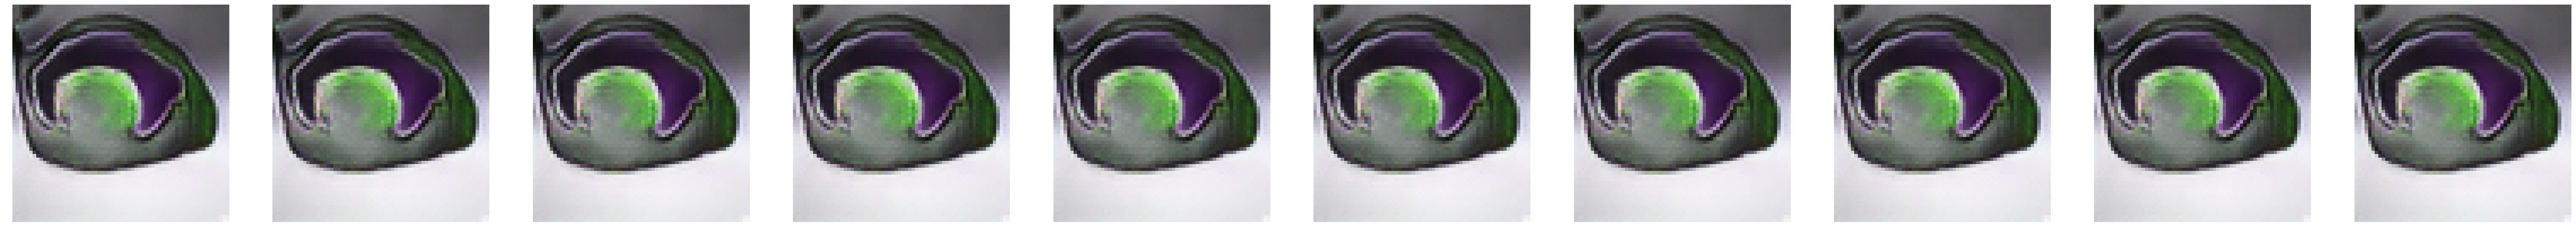

SD=0.075


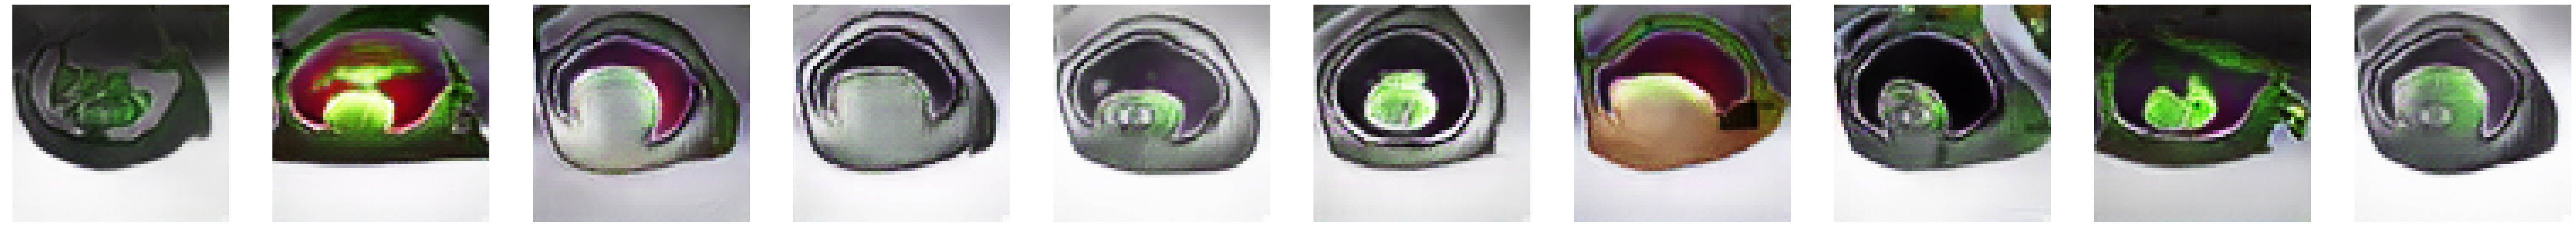

SD=0.15


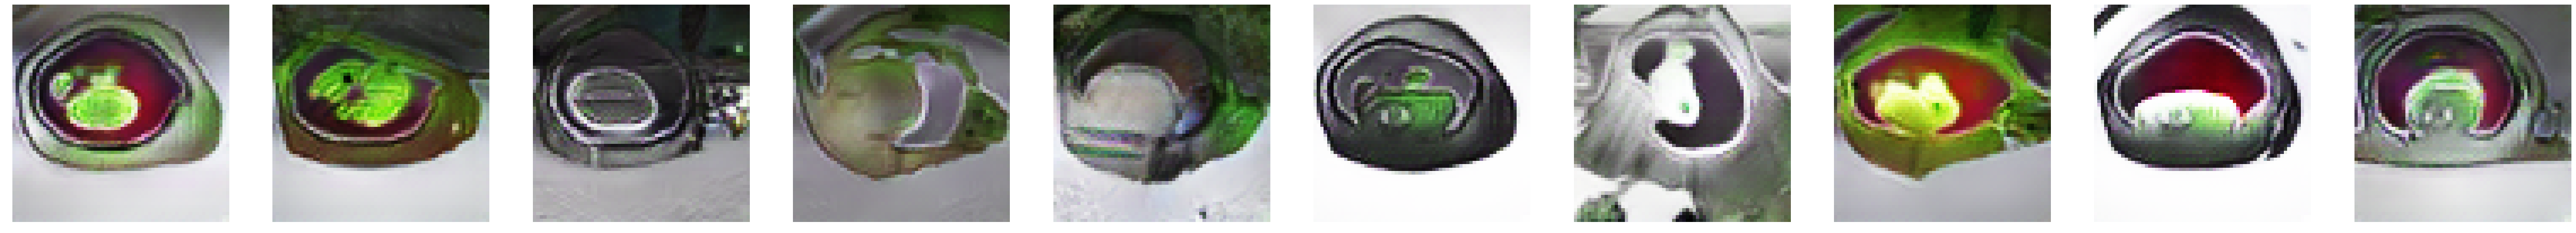

SD=0.225


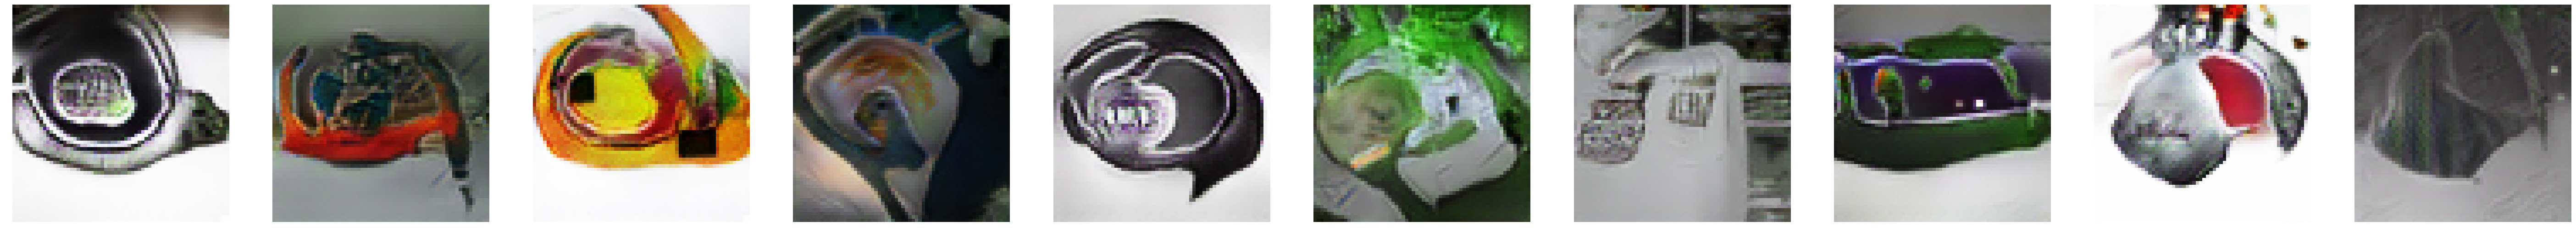

SD=0.3


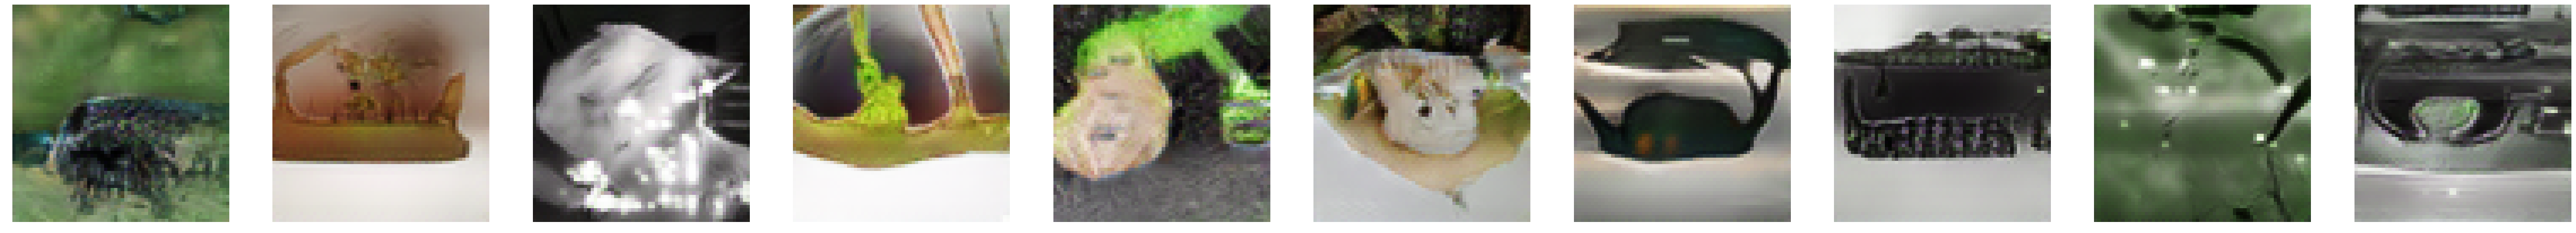

In [11]:
# fix the mean for this experiment.
np.random.seed(42)
mu = np.random.uniform(-1, 1, size=200)

for sd in np.linspace(1e-9, 0.3, 5):
    zs = [sample_z(mu, sd) for _ in range(10)]
    imgs = [_render_image(z) for z in zs]
    print('SD=%s' % np.round(sd, 4))
    imshows(imgs)
    plt.show()

## Distance between category distributions

Likewise, if two category distributions are further apart in feature space, then their samples appear further apart in pixel space as well. Here, we show how rendered stimuli from two category distributions differ as their means drift apart.

reference category, d=0.0


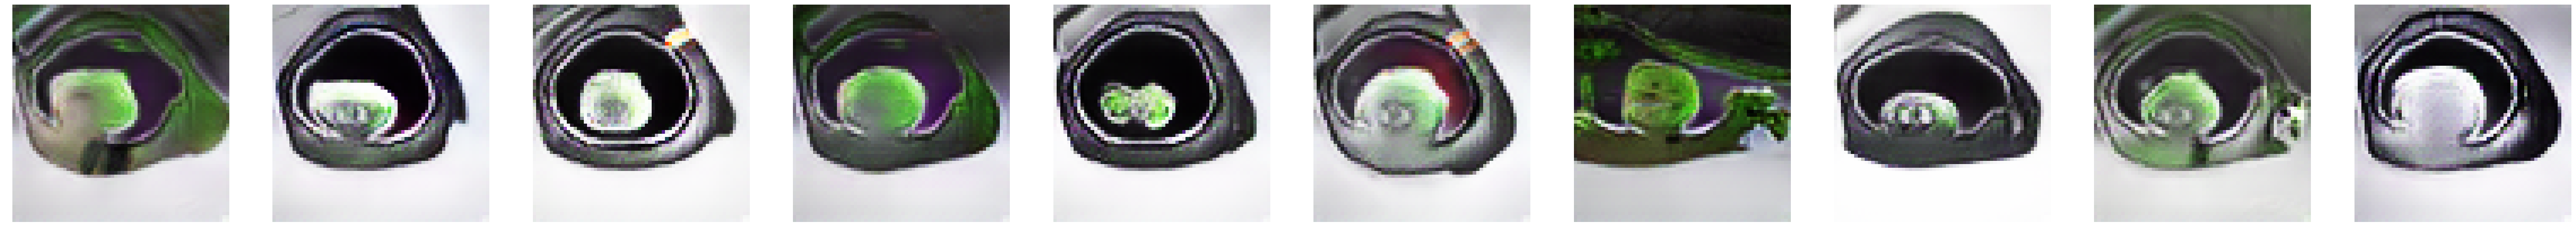

new category, d=3.0


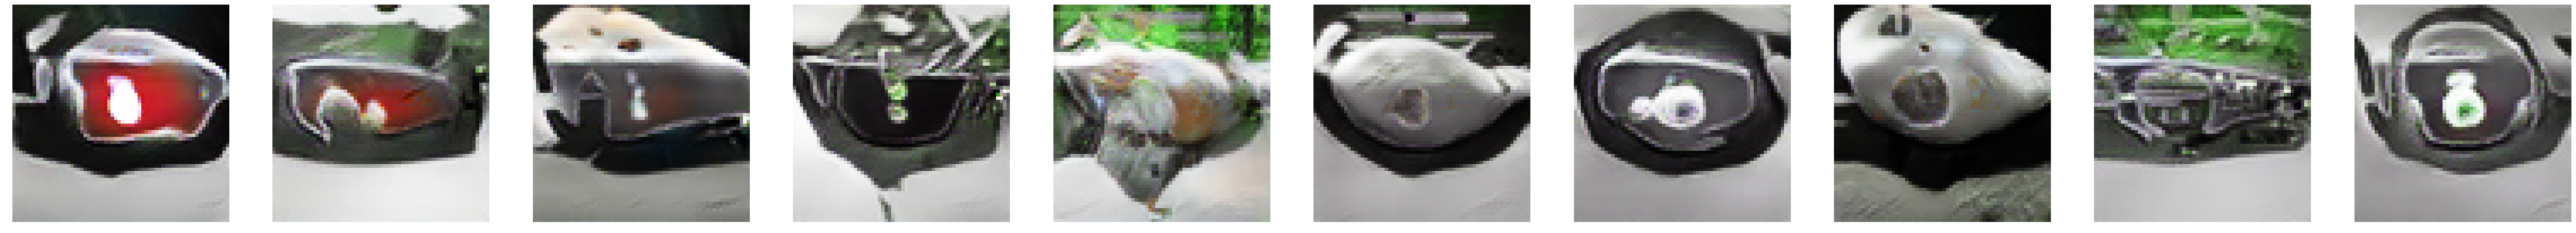

new category, d=6.0


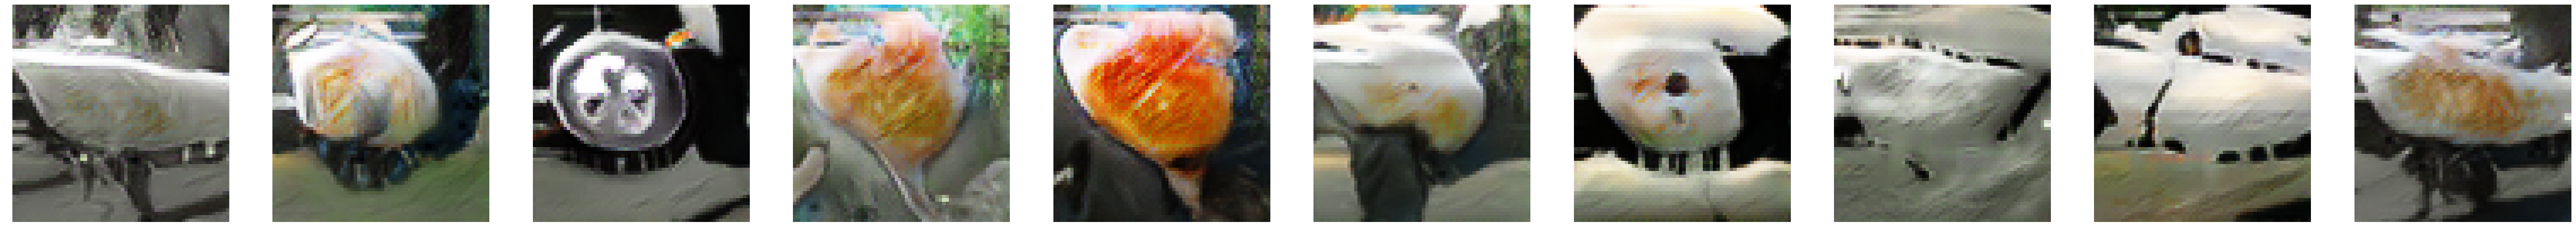

new category, d=9.0


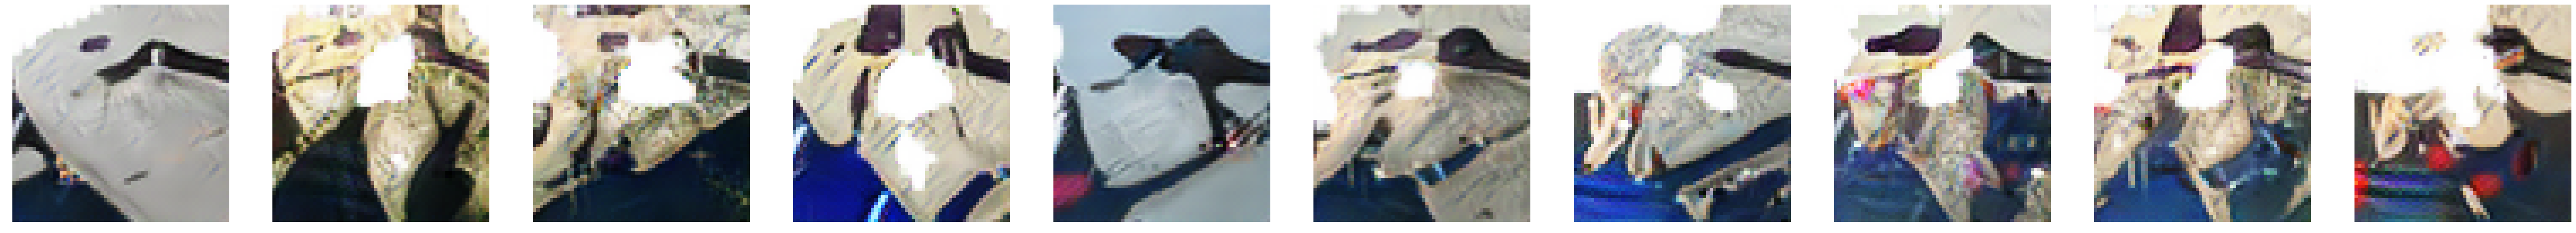

new category, d=12.0


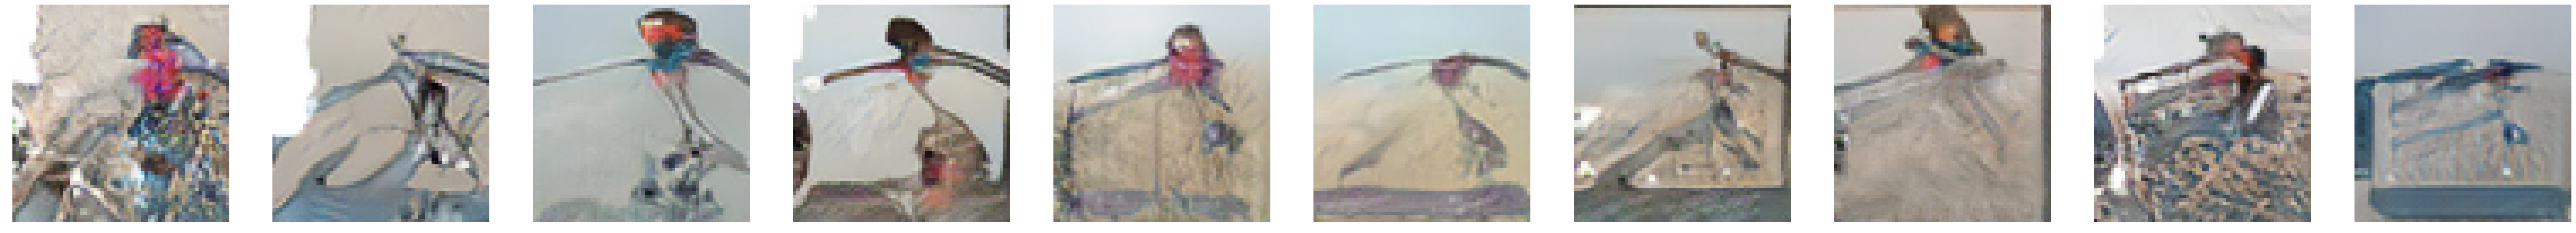

In [16]:
# reference mean for this experiment.
np.random.seed(42)
mu = np.random.uniform(-1, 1, size=200)
# keep the SD fixed for this experiment.
sd = 0.075

# unit direction vector to traverse along
delta = np.random.uniform(-1, 1, size=200)
delta = delta / np.linalg.norm(delta)

for d in np.linspace(1e-9, 12, 5):
    if np.isclose(d, 0):
        print('reference category, d=%s' % np.round(d, 4))
    else:
        print('new category, d=%s' % np.round(d, 4))
    mu_prime = mu + d * delta
    zs = [sample_z(mu_prime, sd) for _ in range(10)]
    imgs = [_render_image(z) for z in zs]
    imshows(imgs)
    plt.show()

## Experiment proposal

### Choosing the category distributions
Having participants learn to distinguish categories while...
* Holding the SDs constant (e.g., 0.1) and varying the distance between distributions.
* Holding the distance constant (e.g., 6.0) and varying the SD.

For SD we can use a <font color=red>0.1, 0.2, and 0.3</font>. For distance we can use <font color=red>3.0, 6.0, and 9.0</font>.

### Varying the sampling dimensions
The SD used in each experiment should be corrected for the number of varying dimensions.
For example, if only 100/200 of the dimensions are being varied, then the effective SD should be

$$
\text{SD}' = \left(\frac{100}{200}\right)^{-1}\text{SD}
$$

For number of dimensions we can use <font color=red>50, 100, and 200</font>.

### Human experiment design

There are two phases to this experiment
1. The phase where the participant learns the categories given a $n$ examples.
2. The phase where the participant is asked to categorize.

For number of examples we can use <font color=red>10, 20, 50</font> (for each category).

### Within/between subject experiments

I need to think about this a little more.